In [25]:
import os

# Define o backend do Keras como TensorFlow
os.environ["KERAS_BACKEND"] = "tensorflow"

# Importações de bibliotecas padrão e de terceiros
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings
import tensorflow_datasets.public_api as tfds
from tensorflow import keras
from keras import layers, Model, Input
from keras.layers import TextVectorization
from keras import ops
from keras import backend as K  # Importa o backend do Keras
import matplotlib.pyplot as plt



### Objetivo do Código: Carregar e Pré-processar Dados para Tradução

Este código realiza o carregamento e pré-processamento de dados a partir de um arquivo `data.tsv` contendo pares de textos em francês e português. A ideia é extrair os pares de textos, adicionar tokens especiais nos textos em português para indicar início e fim das sequências, e em seguida dividir os dados em conjuntos de treinamento, validação e teste para uso posterior no treinamento de modelos de tradução (seq2seq).

#### Passo a Passo do Código:

1. **Carregamento dos Dados**:
   - **Inicialização**:
     - Cria uma lista vazia `text_pairs` para armazenar os pares (francês, português).
   - **Leitura do Arquivo**:
     - Abre o arquivo `data.tsv` em modo leitura com codificação UTF-8.
     - Para cada linha do arquivo:
       - Remove espaços extras com `strip()` e divide a linha em campos usando a tabulação (`\t`) como separador.
       - Verifica se a linha possui pelo menos 4 colunas. Se não, ignora a linha (`continue`).
       - Extrai o texto em francês da segunda coluna (`fields[1]`).
       - Extrai o texto em português da quarta coluna (`fields[3]`) e adiciona tokens especiais `[start]` e `[end]` no início e no final da sequência, respectivamente.
       - Adiciona o par `(french, portuguese)` à lista `text_pairs`.
   - **Verificação Inicial**:
     - Imprime o primeiro par de textos para confirmar que os dados foram carregados corretamente.

2. **Embaralhamento e Divisão dos Dados**:
   - **Embaralhamento**:
     - Embaralha os pares de textos usando `random.shuffle(text_pairs)` para garantir que a divisão subsequente dos conjuntos seja aleatória.
   - **Divisão dos Dados**:
     - Calcula o número de amostras para validação como 15% do total de pares:
       ```python
       num_val_samples = int(0.15 * len(text_pairs))
       ```
     - Define o número de amostras para treinamento como o total menos duas vezes o número de amostras de validação (uma parte para validação e outra para teste):
       ```python
       num_train_samples = len(text_pairs) - 2 * num_val_samples
       ```
     - Separa os pares de textos em:
       - **Conjunto de Treinamento**: os primeiros `num_train_samples` pares.
       - **Conjunto de Validação**: os próximos `num_val_samples` pares.
       - **Conjunto de Teste**: os pares restantes.
   - **Exibição da Distribuição**:
     - Imprime o número total de pares e a quantidade de pares para cada conjunto (treinamento, validação e teste).

---

Esse fluxo garante que os dados estejam bem organizados e distribuídos de maneira aleatória, o que é fundamental para o treinamento robusto de modelos de tradução ou outras tarefas de Processamento de Linguagem Natural.


In [26]:
# ------------------------
# Carregamento e Pré-processamento dos Dados
# ------------------------

# Inicializa uma lista para armazenar os pares de textos (francês e português)
text_pairs = []

# Abre o arquivo 'data.tsv' para leitura, utilizando codificação UTF-8
with open("data.tsv", "r", encoding="utf-8") as f:
    for line in f:
        # Remove espaços extras e divide a linha usando tabulação como separador
        fields = line.strip().split("\t")
        
        # Garante que a linha tenha pelo menos 4 colunas antes de processar
        if len(fields) < 4:
            continue
        
        # Extrai o texto em francês (segunda coluna)
        french = fields[1]
        
        # Extrai o texto em português (quarta coluna) e adiciona tokens de início e fim
        portuguese = "[start] " + fields[3] + " [end]"
        
        # Adiciona o par (francês, português) à lista
        text_pairs.append((french, portuguese))

# Exibe o primeiro par para verificação
print(text_pairs[0])

# Embaralha os pares de textos para garantir aleatoriedade na divisão dos conjuntos
random.shuffle(text_pairs)

# Define o número de amostras para validação (15% do total)
num_val_samples = int(0.15 * len(text_pairs))

# Define o número de amostras para treinamento (o restante após a divisão para validação e teste)
num_train_samples = len(text_pairs) - 2 * num_val_samples

# Divide os pares em conjuntos de treinamento, validação e teste
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

# Exibe o número total de pares e a distribuição entre treinamento, validação e teste
print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

('Je ne supporte pas ce type.', '[start] Eu não suporto esse tipo. [end]')
33030 total pairs
23122 training pairs
4954 validation pairs
4954 test pairs


### Objetivo do Código: Configurar a Padronização e Vetorização dos Textos

Este trecho de código prepara a transformação dos textos brutos para um formato numérico, adequado para o treinamento do modelo. São definidos os caracteres a serem removidos, os parâmetros de vetorização e uma função de padronização customizada, que é aplicada durante o processo de vetorização. Em seguida, as camadas de vetorização para os textos em francês e português são criadas e ajustadas aos dados de treinamento.

#### Passo a Passo do Código:

1. **Definição dos Caracteres a Serem Removidos**:
   - Combina os caracteres de pontuação padrão com os caracteres "«" e "»":
     ```python
     strip_chars = string.punctuation + "«" + "»"
     ```
   - Remove os colchetes `[` e `]` da lista de caracteres a serem removidos, para preservar os tokens especiais (por exemplo, `[start]` e `[end]`):
     ```python
     strip_chars = strip_chars.replace("[", "")
     strip_chars = strip_chars.replace("]", "")
     ```

2. **Configuração dos Parâmetros de Vetorização e Treinamento**:
   - `vocab_size = 25000`: Define o tamanho máximo do vocabulário, ou seja, o número máximo de tokens únicos que serão considerados.
   - `sequence_length = 20`: Define o comprimento máximo das sequências de entrada para o modelo.
   - `batch_size = 64`: Define o tamanho do lote (batch) durante o treinamento.

3. **Definição da Função de Padronização Customizada**:
   - A função `custom_standardization` recebe um texto de entrada e:
     - Converte o texto para letras minúsculas com `tf_strings.lower()`.
     - Remove os caracteres definidos em `strip_chars` utilizando uma expressão regular com `tf_strings.regex_replace()`.


4. **Criação das Camadas de Vetorização**:
   - **Vetorização para o Francês**:
     - Configurada para transformar os textos em sequências de inteiros (índices dos tokens), com um tamanho máximo de sequência definido por `sequence_length`.
     ```python
     french_vectorization = TextVectorization(
         max_tokens=vocab_size,                # Número máximo de tokens no vocabulário
         output_mode="int",                    # Saída como inteiros (índices dos tokens)
         output_sequence_length=sequence_length  # Comprimento fixo da sequência
     )
     ```
   - **Vetorização para o Português**:
     - Configurada de maneira similar à vetorização do francês, porém com `output_sequence_length` definido como `sequence_length + 1`. Esse incremento acomoda o token especial de final de sequência.
     - Utiliza a função de padronização customizada para limpar os textos antes da vetorização.
     ```python
     portuguese_vectorization = TextVectorization(
         max_tokens=vocab_size,                  # Número máximo de tokens no vocabulário
         output_mode="int",                      # Saída como inteiros (índices dos tokens)
         output_sequence_length=sequence_length + 1,  # Comprimento fixo (com 1 extra para o token final)
         standardize=custom_standardization      # Função de padronização personalizada
     )
     ```

5. **Extração dos Textos dos Pares de Treinamento**:
   - Os textos em francês e português são extraídos dos pares de treinamento (`train_pairs`):
     ```python
     train_french_texts = [pair[0] for pair in train_pairs]
     train_portuguese_texts = [pair[1] for pair in train_pairs]
     ```

6. **Adaptação das Camadas de Vetorização aos Dados de Treinamento**:
   - As camadas de vetorização são "adaptadas" aos textos de treinamento. Esse processo faz com que as camadas aprendam o vocabulário e as frequências dos tokens, mapeando cada palavra para um índice inteiro:
     ```python
     french_vectorization.adapt(train_french_texts)
     portuguese_vectorization.adapt(train_portuguese_texts)
     ```

---

Este processo é crucial para transformar os dados textuais brutos em um formato numérico consistente, preparando-os para o treinamento de modelos de tradução ou outras aplicações de NLP.


In [27]:
# Define os caracteres que serão removidos durante a padronização dos textos
strip_chars = string.punctuation + "«" + "»"
strip_chars = strip_chars.replace("[", "")  # Remove colchete de abertura da lista de caracteres
strip_chars = strip_chars.replace("]", "")  # Remove colchete de fechamento da lista de caracteres

# Parâmetros para a vetorização dos textos e treinamento do modelo
vocab_size = 25000          # Tamanho máximo do vocabulário para vetorização
sequence_length = 20        # Comprimento máximo das sequências de entrada
batch_size = 64             # Tamanho do lote (batch) durante o treinamento

def custom_standardization(input_string):
    """
    Padroniza o texto convertendo para minúsculas e removendo caracteres indesejados.

    Args:
        input_string (Tensor): Texto de entrada a ser padronizado.

    Returns:
        Tensor: Texto padronizado com caracteres removidos.
    """
    lowercase = tf_strings.lower(input_string)  # Converte o texto para minúsculas
    return tf_strings.regex_replace(
        lowercase, 
        "[%s]" % re.escape(strip_chars),  # Remove os caracteres definidos em 'strip_chars'
        ""
    )

# Vetorização dos textos em francês
french_vectorization = TextVectorization(
    max_tokens=vocab_size,                # Número máximo de tokens no vocabulário
    output_mode="int",                    # Saída como inteiros (índices dos tokens)
    output_sequence_length=sequence_length  # Comprimento fixo da sequência
)

# Vetorização dos textos em português com padronização personalizada
portuguese_vectorization = TextVectorization(
    max_tokens=vocab_size,                  # Número máximo de tokens no vocabulário
    output_mode="int",                      # Saída como inteiros (índices dos tokens)
    output_sequence_length=sequence_length + 1,  # Comprimento fixo (com 1 extra para o token final)
    standardize=custom_standardization      # Função de padronização personalizada
)

# Extrai os textos em francês e português dos pares de treinamento
train_french_texts = [pair[0] for pair in train_pairs]
train_portuguese_texts = [pair[1] for pair in train_pairs]

# Ajusta (adapta) as camadas de vetorização aos textos de treinamento
french_vectorization.adapt(train_french_texts)
portuguese_vectorization.adapt(train_portuguese_texts)


### Objetivo do Código: Formatar e Criar o Dataset para Treinamento e Validação de um Modelo Seq2Seq

Este trecho de código define duas funções para preparar os dados textuais em um formato adequado para o treinamento de um modelo seq2seq. Os dados são compostos por pares de textos em francês e português, e o processo de formatação envolve a vetorização dos textos e o ajuste das sequências para o funcionamento do modelo encoder-decoder.

---

#### Função `format_dataset`

**Descrição:**  
Converte os textos brutos em sequências numéricas utilizando as camadas de vetorização pré-definidas e organiza os dados em entradas para o encoder e decoder, bem como os alvos para o treinamento do decoder.

**Entradas:**
- `french` (Tensor): Textos em francês, que serão utilizados como entrada do encoder.
- `portuguese` (Tensor): Textos em português, que serão utilizados tanto como entrada quanto como alvo do decoder.

**Processamento:**
1. **Vetoriza o Texto em Francês:**  
   - Converte o texto em francês em sequências numéricas usando `french_vectorization`.
2. **Vetoriza o Texto em Português:**  
   - Converte o texto em português em sequências numéricas usando `portuguese_vectorization`.
3. **Organiza os Dados para o Decoder:**
   - **`decoder_inputs`:** São obtidos removendo o último token da sequência vetorizada em português. Essa sequência serve de entrada para o decoder durante o treinamento (input feeding).
   - **Alvo do Decoder (`decoder_target`):** É obtido removendo o primeiro token da sequência vetorizada em português. Essa sequência é a que o modelo deve aprender a prever.

**Saída:**
- Retorna uma tupla contendo:
  - Um dicionário com:
    - `"encoder_inputs"`: Sequência vetorizada em francês.
    - `"decoder_inputs"`: Sequência vetorizada em português sem o último token.
  - A sequência de rótulos para o decoder (texto em português sem o primeiro token).

---

#### Função `make_dataset`

**Descrição:**  
Cria um `tf.data.Dataset` formatado a partir dos pares de textos, aplicando as etapas de batching, mapeamento, cache, shuffle e prefetch para otimizar o pipeline de dados durante o treinamento e a validação.

**Entradas:**
- `pairs` (list): Lista de tuplas, onde cada tupla contém um par de textos (francês, português).

**Processamento:**
1. **Separação dos Textos:**  
   - Utiliza `zip(*pairs)` para descompactar os pares em duas listas: uma para os textos em francês e outra para os textos em português.
2. **Criação do Dataset:**  
   - Converte as listas em um dataset TensorFlow utilizando `tf_data.Dataset.from_tensor_slices`.
3. **Batching:**  
   - Agrupa os dados em lotes com o tamanho definido por `batch_size`.
4. **Mapeamento:**  
   - Aplica a função `format_dataset` para converter cada lote de textos brutos em um formato compatível com o modelo.
5. **Otimização do Pipeline:**  
   - Utiliza `cache()` para armazenar em cache o dataset.
   - Embaralha os dados com `shuffle(2048)` para garantir aleatoriedade.
   - Pré-carrega os dados com `prefetch(16)` para melhorar a performance durante o treinamento.

**Saída:**
- Retorna um `tf.data.Dataset` pronto para ser usado nos processos de treinamento ou validação.


---

#### Uso dos Datasets

Os datasets de treinamento e validação são criados utilizando as funções definidas:

```python
# Cria os datasets de treinamento e validação utilizando os pares correspondentes
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
```

Esses datasets serão usados para treinar e validar o modelo seq2seq, garantindo que os dados estejam no formato correto e que o pipeline de entrada seja eficiente.


In [28]:
def format_dataset(french, portuguese):
    """
    Formata os pares de textos em francês e português para o modelo seq2seq.

    Args:
        french (Tensor): Textos em francês.
        portuguese (Tensor): Textos em português.

    Returns:
        Tuple: Um dicionário com as entradas do encoder e do decoder, 
               e o alvo do decoder para o treinamento.
    """
    # Vetoriza o texto em francês (entrada do encoder)
    french = french_vectorization(french)
    
    # Vetoriza o texto em português (entrada e alvo do decoder)
    portuguese = portuguese_vectorization(portuguese)
    
    return (
        {
            "encoder_inputs": french,  # Entrada do encoder
            "decoder_inputs": portuguese[:, :-1],  # Entrada do decoder (sem o último token)
        },
        portuguese[:, 1:]  # Alvo do decoder (sem o primeiro token)
    )


def make_dataset(pairs):
    """
    Cria um dataset formatado a partir dos pares de texto.

    Args:
        pairs (list): Lista de tuplas contendo os textos em francês e português.

    Returns:
        tf.data.Dataset: Dataset formatado para o treinamento e validação.
    """
    # Separa os textos em francês e português dos pares
    french_texts, portuguese_texts = zip(*pairs)
    
    # Cria um dataset TensorFlow a partir dos textos
    dataset = tf_data.Dataset.from_tensor_slices(
        (list(french_texts), list(portuguese_texts))
    )
    
    # Agrupa os dados em lotes (batch)
    dataset = dataset.batch(batch_size)
    
    # Aplica a função de formatação para preparar as entradas e alvos
    dataset = dataset.map(format_dataset)
    
    # Armazena em cache, embaralha e pré-carrega os dados para otimização
    return dataset.cache().shuffle(2048).prefetch(16)


# Cria os datasets de treinamento e validação utilizando os pares correspondentes
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)


### Objetivo do Código: Implementar uma Camada de Embedding Posicional com Regularização Aprimorada

Esta classe, `PositionalEmbedding`, é uma camada customizada do Keras que combina os embeddings dos tokens com embeddings posicionais. Essa combinação permite que o modelo capture não apenas a representação semântica dos tokens, mas também a informação sobre sua posição relativa na sequência, o que é essencial para muitas tarefas de Processamento de Linguagem Natural (NLP).

---

#### 1. Inicialização da Camada (`__init__`)

- **Parâmetros:**
  - `sequence_length` (int): Comprimento máximo da sequência. Define quantas posições a camada pode representar.
  - `vocab_size` (int): Tamanho do vocabulário, ou seja, o número máximo de tokens únicos.
  - `embed_dim` (int): Dimensão do vetor de embedding para cada token e para cada posição.
  - `**kwargs`: Argumentos adicionais para a classe base `Layer`.

- **Componentes Internos:**
  - `self.token_embeddings`: Camada de embedding que mapeia cada token para um vetor de dimensão `embed_dim`.
  - `self.position_embeddings`: Camada de embedding que mapeia cada posição na sequência para um vetor de dimensão `embed_dim`.

- **Armazenamento de Parâmetros:**
  - Os parâmetros `sequence_length`, `vocab_size` e `embed_dim` são armazenados como atributos da classe para uso posterior e para possibilitar a serialização da camada.

---

#### 2. Método `call`

- **Objetivo:**
  - Combinar os embeddings dos tokens com os embeddings das posições correspondentes, enriquecendo as representações dos tokens com a informação posicional.

- **Processo:**
  1. **Determinar o Comprimento da Sequência:**
     - `length = ops.shape(inputs)[-1]`
       - Obtém o comprimento da sequência a partir do shape do tensor de entrada.
  2. **Gerar Índices de Posição:**
     - `positions = ops.arange(0, length, 1)`
       - Cria um tensor que representa as posições de 0 até `length - 1`.
  3. **Aplicar Embeddings:**
     - `embedded_tokens = self.token_embeddings(inputs)`
       - Converte os tokens de entrada em seus respectivos vetores de embedding.
     - `embedded_positions = self.position_embeddings(positions)`
       - Converte os índices de posição em vetores de embedding.
  4. **Combinar os Embeddings:**
     - Retorna a soma dos embeddings dos tokens com os embeddings das posições:
       ```python
       return embedded_tokens + embedded_positions
       ```
       
- **Saída:**
  - Um tensor de shape `(batch_size, sequence_length, embed_dim)` contendo os embeddings enriquecidos com a informação de posição.

---

#### 3. Método `compute_mask`

- **Objetivo:**
  - Gerar uma máscara para ignorar os tokens de padding (por exemplo, tokens com valor 0) durante o processamento.

- **Processo:**
  - Utiliza `ops.not_equal(inputs, 0)` para criar uma máscara booleana onde:
    - `True` indica que o token é válido (diferente de 0).
    - `False` indica que o token é padding.

- **Saída:**
  - Um tensor de máscara que pode ser usado pelas camadas subsequentes para ignorar os tokens de padding.

---

#### 4. Método `get_config`

- **Objetivo:**
  - Permitir a serialização e reconstrução da camada, retornando sua configuração em forma de dicionário.

- **Processo:**
  - Chama `super().get_config()` para obter as configurações da camada base e atualiza esse dicionário com os parâmetros:
    - `sequence_length`
    - `vocab_size`
    - `embed_dim`

- **Saída:**
  - Um dicionário com a configuração completa da camada, garantindo que ela possa ser salva e carregada corretamente.

---

#### Resumo

A camada `PositionalEmbedding` é fundamental para modelos que precisam entender a ordem dos tokens. Ao combinar embeddings de tokens com embeddings posicionais, ela fornece ao modelo informações estruturais essenciais para capturar relações sequenciais, melhorando a performance em tarefas como tradução, sumarização e outras aplicações de NLP.


In [29]:
# ------------------------
# Componentes do Modelo com Regularização Aprimorada
# ------------------------

class PositionalEmbedding(layers.Layer):
    """
    Camada personalizada para aplicar embeddings de tokens combinados com embeddings posicionais.
    Isso permite que o modelo entenda a ordem dos tokens na sequência.
    """
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        """
        Inicializa a camada de embeddings posicionais.

        Args:
            sequence_length (int): Comprimento máximo da sequência.
            vocab_size (int): Tamanho do vocabulário (número máximo de tokens).
            embed_dim (int): Dimensão do vetor de embedding.
            **kwargs: Argumentos adicionais para a classe base `Layer`.
        """
        super().__init__(**kwargs)
        
        # Embedding para os tokens (representação vetorial de cada palavra/token)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, 
            output_dim=embed_dim
        )
        
        # Embedding para a posição de cada token na sequência
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, 
            output_dim=embed_dim
        )
        
        # Armazena os parâmetros para reutilização e configuração
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        """
        Combina embeddings dos tokens com seus respectivos embeddings posicionais.

        Args:
            inputs (Tensor): Sequência de tokens (shape: batch_size, sequence_length).

        Returns:
            Tensor: Embedding combinado de tokens e posições (shape: batch_size, sequence_length, embed_dim).
        """
        # Obtém o comprimento da sequência (última dimensão da entrada)
        length = ops.shape(inputs)[-1]
        
        # Cria um tensor representando as posições (0, 1, 2, ..., length - 1)
        positions = ops.arange(0, length, 1)
        
        # Aplica o embedding nos tokens
        embedded_tokens = self.token_embeddings(inputs)
        
        # Aplica o embedding nas posições
        embedded_positions = self.position_embeddings(positions)
        
        # Combina o embedding dos tokens com o embedding das posições
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        """
        Gera uma máscara para ignorar o padding (valores iguais a 0).

        Args:
            inputs (Tensor): Sequência de entrada.
            mask (Tensor, opcional): Máscara existente.

        Returns:
            Tensor: Máscara onde valores diferentes de zero são marcados como válidos.
        """
        # Cria a máscara usando `ops.not_equal` para detectar tokens válidos (diferentes de 0)
        return ops.not_equal(inputs, 0)

    def get_config(self):
        """
        Retorna a configuração da camada para permitir a serialização do modelo.

        Returns:
            dict: Configurações da camada, incluindo comprimento da sequência, 
                  tamanho do vocabulário e dimensão do embedding.
        """
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


### Objetivo do Código: Implementar um Encoder Transformer com Dropout e Regularização Aprimorada

Esta classe define um encoder baseado na arquitetura Transformer, que incorpora atenção multi-cabeça, redes feedforward e normalização em camadas, além de aplicar regularização via dropout em pontos críticos do fluxo. Essa implementação é essencial para construir modelos que lidam com sequências de forma eficiente e robusta, mitigando o overfitting e melhorando a generalização.

---

#### 1. Inicialização da Camada (`__init__`)

- **Parâmetros de Entrada:**
  - `embed_dim` (int): Dimensão dos embeddings de entrada.
  - `dense_dim` (int): Dimensão interna da rede feedforward.
  - `num_heads` (int): Número de cabeças de atenção na camada multi-head.
  - `dropout_rate` (float): Taxa de dropout aplicada após a atenção e a rede feedforward.
  - `**kwargs`: Argumentos adicionais passados para a classe base `Layer`.

- **Componentes Críticos:**
  - **Atenção Multi-Cabeça:**  
    Utiliza `layers.MultiHeadAttention` para permitir que o modelo foque em diferentes partes da sequência simultaneamente.  
    ```python
    self.attention = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim
    )
    ```
  - **Dropout após a Atenção:**  
    Aplica regularização ao output da camada de atenção para reduzir o overfitting.  
    ```python
    self.dropout_att = layers.Dropout(dropout_rate)
    ```
  - **Rede Feedforward:**  
    Uma sequência de duas camadas densas que processa a saída da camada de atenção:  
    - Primeira camada: Projeção para uma dimensão `dense_dim` com ativação ReLU.
    - Segunda camada: Projeção de volta para `embed_dim`.
    ```python
    self.dense_proj = keras.Sequential([
        layers.Dense(dense_dim, activation="relu"),
        layers.Dense(embed_dim),
    ])
    ```
  - **Dropout após o Feedforward:**  
    Aplica dropout ao output da rede feedforward para regularização adicional.  
    ```python
    self.dropout_ffn = layers.Dropout(dropout_rate)
    ```
  - **Normalização em Camadas:**  
    Duas camadas de `LayerNormalization` são utilizadas para estabilizar a aprendizagem e melhorar a convergência:
    - `self.layernorm_1`: Após a soma residual com a atenção.
    - `self.layernorm_2`: Após a soma residual com o feedforward.
  - **Suporte a Máscaras:**  
    Define `self.supports_masking = True` para permitir que a camada ignore tokens de padding durante o processamento.

---

#### 2. Método `call`

- **Entradas:**
  - `inputs` (Tensor): Tensor de entrada com shape `(batch_size, sequence_length, embed_dim)`.
  - `mask` (Tensor, opcional): Máscara para ignorar posições de padding.
  - `training` (bool, opcional): Flag que indica se a camada está em modo de treinamento, para controlar a aplicação do dropout.

- **Processamento Passo a Passo:**

  1. **Preparação da Máscara:**  
     Se uma máscara for fornecida, ela é ajustada para compatibilidade com a atenção, expandindo a dimensão do eixo das cabeças:
     ```python
     if mask is not None:
         padding_mask = tf.cast(mask[:, None, :], dtype="int32")
     else:
         padding_mask = None
     ```
  
  2. **Atenção Multi-Cabeça:**  
     A camada de atenção é aplicada com os mesmos `inputs` como query, key e value, utilizando a máscara (se houver):
     ```python
     attention_output = self.attention(
         query=inputs,
         value=inputs,
         key=inputs,
         attention_mask=padding_mask
     )
     ```
  
  3. **Dropout na Atenção:**  
     Aplica dropout ao resultado da atenção, somente durante o treinamento:
     ```python
     attention_output = self.dropout_att(attention_output, training=training)
     ```
  
  4. **Soma Residual e Normalização (Atenção):**  
     Soma o output da atenção com o input original e normaliza o resultado:
     ```python
     proj_input = self.layernorm_1(inputs + attention_output)
     ```
  
  5. **Rede Feedforward:**  
     Processa a saída normalizada por meio da rede feedforward:
     ```python
     proj_output = self.dense_proj(proj_input)
     ```
  
  6. **Dropout na Rede Feedforward:**  
     Aplica dropout ao resultado da rede feedforward durante o treinamento:
     ```python
     proj_output = self.dropout_ffn(proj_output, training=training)
     ```
  
  7. **Soma Residual e Normalização (Feedforward):**  
     Soma a entrada normalizada (após atenção) com o output do feedforward e aplica normalização final:
     ```python
     return self.layernorm_2(proj_input + proj_output)
     ```

- **Saída:**
  - Um tensor de saída com a mesma forma que o input, enriquecido com as operações de atenção, feedforward e normalização.

---

#### 3. Método `get_config`

- **Objetivo:**
  - Permitir a serialização e a reconstrução da camada, retornando suas configurações essenciais.

- **Processo:**
  - Recupera a configuração base da camada e a atualiza com os parâmetros `embed_dim`, `dense_dim` e `num_heads`.
  - Retorna o dicionário de configuração.

```python
def get_config(self):
    config = super().get_config()
    config.update({
        "embed_dim": self.embed_dim,
        "dense_dim": self.dense_dim,
        "num_heads": self.num_heads,
    })
    return config
```

---

### Resumo

A classe `TransformerEncoder` implementa um encoder Transformer completo com:
- **Atenção Multi-Cabeça:** Para capturar diferentes relacionamentos entre tokens.
- **Redes Feedforward:** Para transformar as representações obtidas pela atenção.
- **Dropout:** Aplicado após a atenção e a rede feedforward, visando regularização.
- **Normalização em Camadas:** Para estabilizar e acelerar o treinamento.
- **Suporte a Máscaras:** Permite o tratamento de tokens de padding.

Essa implementação é essencial para construir modelos Transformer robustos e eficientes em tarefas como tradução, classificação de texto, e outras aplicações em NLP.


In [30]:
# Transformer Encoder com Dropout adicionado nas camadas de atenção e feedforward
class TransformerEncoder(layers.Layer):
    """
    Encoder do Transformer que aplica atenção multi-cabeça, normalização em camadas
    e redes feedforward, com regularização por Dropout.
    """
    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate=0.1, **kwargs):
        """
        Inicializa o Transformer Encoder.

        Args:
            embed_dim (int): Dimensão dos embeddings de entrada.
            dense_dim (int): Dimensão da rede feedforward interna.
            num_heads (int): Número de cabeças de atenção.
            dropout_rate (float): Taxa de dropout para regularização.
            **kwargs: Argumentos adicionais para a classe base `Layer`.
        """
        super().__init__(**kwargs)

        # Parâmetros da camada
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Camada de Atenção Multi-Cabeça
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )

        # Dropout aplicado após a camada de atenção
        self.dropout_att = layers.Dropout(dropout_rate)

        # Rede feedforward composta por duas camadas densas
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])

        # Dropout aplicado após a rede feedforward
        self.dropout_ffn = layers.Dropout(dropout_rate)

        # Normalização em camadas aplicada após a atenção e o feedforward
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

        # Indica que a camada suporta mascaramento (útil para lidar com padding)
        self.supports_masking = True

    def call(self, inputs, mask=None, training=False):
        """
        Executa a passagem dos dados pela camada Transformer Encoder.

        Args:
            inputs (Tensor): Tensor de entrada (batch_size, sequence_length, embed_dim).
            mask (Tensor, opcional): Máscara para ignorar posições de padding.
            training (bool, opcional): Indica se a camada está em modo de treinamento.

        Returns:
            Tensor: Saída do encoder após atenção, feedforward e normalização.
        """
        # Se uma máscara for fornecida, ajusta o formato para ser compatível com a atenção
        if mask is not None:
            padding_mask = tf.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        # Aplica a atenção multi-cabeça com a máscara de padding (se existir)
        attention_output = self.attention(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=padding_mask
        )

        # Aplica Dropout após a atenção (apenas durante o treinamento)
        attention_output = self.dropout_att(attention_output, training=training)

        # Normaliza a soma residual entre a entrada e a saída da atenção
        proj_input = self.layernorm_1(inputs + attention_output)

        # Passa pela rede feedforward
        proj_output = self.dense_proj(proj_input)

        # Aplica Dropout após o feedforward (apenas durante o treinamento)
        proj_output = self.dropout_ffn(proj_output, training=training)

        # Normaliza a soma residual entre o input normalizado e a saída do feedforward
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        """
        Retorna a configuração da camada para permitir a serialização do modelo.

        Returns:
            dict: Configurações da camada, incluindo embed_dim, dense_dim e num_heads.
        """
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


### Objetivo do Código: Implementar um Transformer Decoder com Dropout e Regularização Aprimorada

Esta classe, `TransformerDecoder`, define um decoder do Transformer que incorpora duas subcamadas de atenção (self-attention e cross-attention), uma rede feedforward e várias operações de regularização, como dropout e normalização em camadas. O decoder também utiliza uma máscara causal para garantir que a previsão de cada token não dependa de tokens futuros, mantendo a propriedade autoregressiva durante a geração de sequência.

---

#### 1. Inicialização da Camada (`__init__`)

- **Parâmetros de Entrada:**
  - `embed_dim` (int): Dimensão dos embeddings de entrada.
  - `latent_dim` (int): Dimensão interna da rede feedforward.
  - `num_heads` (int): Número de cabeças de atenção multi-head.
  - `dropout_rate` (float): Taxa de dropout aplicada após cada subcamada, com valor padrão de 0.1.
  - `**kwargs`: Argumentos adicionais para a classe base `Layer`.

- **Componentes Criados:**
  - **Primeira Atenção Multi-Cabeça (Self-Attention):**
    - `self.attention_1`: Camada de self-attention para processar os inputs do decoder.
    - `self.dropout_att1`: Dropout aplicado ao output da self-attention.
    
  - **Segunda Atenção Multi-Cabeça (Cross-Attention):**
    - `self.attention_2`: Camada de cross-attention que utiliza a saída do encoder para refinar as representações do decoder.
    - `self.dropout_att2`: Dropout aplicado após a cross-attention.
    
  - **Rede Feedforward:**
    - `self.dense_proj`: Uma rede feedforward composta por duas camadas densas:
      - A primeira camada projeta para uma dimensão `latent_dim` com ativação ReLU.
      - A segunda camada retorna ao espaço de `embed_dim`.
    - `self.dropout_ffn`: Dropout aplicado à saída da rede feedforward.
    
  - **Normalizações em Camadas:**
    - `self.layernorm_1`: Normaliza a soma residual após a self-attention.
    - `self.layernorm_2`: Normaliza a soma residual após a cross-attention.
    - `self.layernorm_3`: Normaliza a soma residual após a rede feedforward.
    
  - **Suporte a Máscaras:**
    - `self.supports_masking = True` indica que a camada pode processar inputs com máscaras (útil para ignorar padding).

---

#### 2. Método `call`

- **Entradas:**
  - `inputs` (tuple): Contém uma tupla `(decoder_inputs, encoder_outputs)`:
    - `decoder_inputs`: Representa a sequência de entrada do decoder (normalmente já embutida).
    - `encoder_outputs`: Saída do encoder, que será utilizada na cross-attention.
  - `mask` (tuple, opcional): Contém duas máscaras:
    - `decoder_padding_mask`: Para ignorar tokens de padding no decoder.
    - `encoder_padding_mask`: Para ignorar tokens de padding no encoder.
  - `training` (bool, opcional): Indica se a camada está em modo de treinamento para ativar o dropout.

- **Fluxo de Processamento:**

  1. **Geração da Máscara Causal:**
     - Chama `self.get_causal_attention_mask(decoder_inputs)` para criar uma máscara que impede o acesso a tokens futuros, garantindo a propriedade autoregressiva.
  
  2. **Processamento da Self-Attention (Primeira Atenção Multi-Cabeça):**
     - Aplica `self.attention_1` aos `decoder_inputs` usando a máscara causal (e opcionalmente uma máscara de padding para o decoder).
     - O resultado passa pelo dropout `self.dropout_att1`.
     - Realiza uma soma residual entre o input original e o output da atenção, seguido de normalização com `self.layernorm_1`, produzindo `out_1`.
  
  3. **Processamento da Cross-Attention (Segunda Atenção Multi-Cabeça):**
     - Aplica `self.attention_2` utilizando `out_1` como query e os `encoder_outputs` como key e value. As máscaras para o decoder e o encoder são aplicadas, se fornecidas.
     - O output é submetido ao dropout `self.dropout_att2`.
     - Realiza a soma residual de `out_1` e o output da cross-attention, seguido de normalização com `self.layernorm_2`, resultando em `out_2`.
  
  4. **Rede Feedforward:**
     - Processa `out_2` através da rede feedforward `self.dense_proj`.
     - Aplica dropout à saída com `self.dropout_ffn`.
     - Realiza a soma residual de `out_2` com o output do feedforward e aplica uma última normalização com `self.layernorm_3`.
  
  5. **Saída:**
     - Retorna o tensor resultante que integra as operações de atenção (self e cross), feedforward e normalização, pronto para ser passado para as camadas subsequentes ou para gerar predições.

---

#### 3. Método `get_causal_attention_mask`

- **Objetivo:**
  - Gerar uma máscara causal que impede que cada posição do decoder acesse tokens futuros.
  
- **Processo:**
  - Calcula o comprimento da sequência (`seq_length`) a partir do tensor `inputs`.
  - Cria uma matriz lower-triangular (usando `tf.range` e comparações) onde cada posição `i` só pode ver posições `j` onde `j ≤ i`.
  - Ajusta a forma da máscara para compatibilidade com a atenção multi-cabeça e a replica para o tamanho do batch.

- **Saída:**
  - Um tensor de máscara com shape `(batch_size, seq_length, seq_length)`.

---

#### 4. Método `get_config`

- **Objetivo:**
  - Permitir a serialização da camada retornando um dicionário com as configurações principais.
  
- **Processo:**
  - Chama `super().get_config()` para obter a configuração base e atualiza o dicionário com os parâmetros:
    - `embed_dim`
    - `latent_dim`
    - `num_heads`
  
- **Saída:**
  - Um dicionário contendo as configurações da camada, facilitando sua serialização e posterior reconstrução.

```python
def get_config(self):
    config = super().get_config()
    config.update({
        "embed_dim": self.embed_dim,
        "latent_dim": self.latent_dim,
        "num_heads": self.num_heads,
    })
    return config
```

---

### Resumo

A classe `TransformerDecoder` implementa um decoder Transformer robusto com:
- **Self-Attention Causal:** Garante que cada token não possa ver o futuro, mantendo o caráter autoregressivo.
- **Cross-Attention:** Permite ao decoder integrar informações relevantes do encoder.
- **Rede Feedforward:** Processa as representações combinadas para obter features mais refinadas.
- **Dropout e Normalização:** Aplicados após cada subcamada para regularização e estabilidade durante o treinamento.
- **Suporte a Máscaras:** Trata adequadamente o padding em ambas as entradas do decoder e do encoder.

Essa estrutura é fundamental para tarefas como tradução automática, geração de texto e outras aplicações que utilizam a arquitetura Transformer.


In [31]:
# Transformer Decoder com Dropout adicionado nas subcamadas de atenção e na rede feedforward
class TransformerDecoder(layers.Layer):
    """
    Decoder do Transformer que aplica atenção causal, cross-attention com a saída do encoder,
    normalização em camadas e redes feedforward, com regularização por Dropout.
    """
    def __init__(self, embed_dim, latent_dim, num_heads, dropout_rate=0.1, **kwargs):
        """
        Inicializa o Transformer Decoder.

        Args:
            embed_dim (int): Dimensão dos embeddings de entrada.
            latent_dim (int): Dimensão da rede feedforward interna.
            num_heads (int): Número de cabeças de atenção.
            dropout_rate (float): Taxa de dropout para regularização.
            **kwargs: Argumentos adicionais para a classe base `Layer`.
        """
        super().__init__(**kwargs)

        # Parâmetros do decoder
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads

        # Primeira camada de Atenção Multi-Cabeça (Self-Attention com máscara causal)
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.dropout_att1 = layers.Dropout(dropout_rate)

        # Segunda camada de Atenção Multi-Cabeça (Cross-Attention com saída do encoder)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.dropout_att2 = layers.Dropout(dropout_rate)

        # Rede feedforward com ativação ReLU
        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.dropout_ffn = layers.Dropout(dropout_rate)

        # Normalização em camadas após cada subcamada do decoder
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        # Indica que a camada suporta mascaramento (útil para lidar com padding)
        self.supports_masking = True

    def call(self, inputs, mask=None, training=False):
        """
        Executa a passagem dos dados pela camada Transformer Decoder.

        Args:
            inputs (tuple): Tupla contendo (decoder_inputs, encoder_outputs).
            mask (tuple, opcional): Máscaras para o decoder e o encoder.
            training (bool, opcional): Indica se a camada está em modo de treinamento.

        Returns:
            Tensor: Saída do decoder após atenção, feedforward e normalização.
        """
        decoder_inputs, encoder_outputs = inputs

        # Cria a máscara causal para evitar que o decoder veja tokens futuros
        causal_mask = self.get_causal_attention_mask(decoder_inputs)

        # Se uma máscara for fornecida, separa as máscaras do decoder e do encoder
        if mask is None:
            decoder_padding_mask, encoder_padding_mask = None, None
        else:
            decoder_padding_mask, encoder_padding_mask = mask

        # Primeira Atenção Multi-Cabeça (Self-Attention com máscara causal)
        attention_output_1 = self.attention_1(
            query=decoder_inputs,
            value=decoder_inputs,
            key=decoder_inputs,
            attention_mask=causal_mask,
            query_mask=decoder_padding_mask,
        )
        attention_output_1 = self.dropout_att1(attention_output_1, training=training)

        # Soma residual e normalização após a primeira atenção
        out_1 = self.layernorm_1(decoder_inputs + attention_output_1)

        # Segunda Atenção Multi-Cabeça (Cross-Attention com saída do encoder)
        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=decoder_padding_mask,
            key_mask=encoder_padding_mask,
        )
        attention_output_2 = self.dropout_att2(attention_output_2, training=training)

        # Soma residual e normalização após a cross-attention
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        # Passagem pela rede feedforward
        proj_output = self.dense_proj(out_2)
        proj_output = self.dropout_ffn(proj_output, training=training)

        # Soma residual e normalização após a rede feedforward
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        """
        Gera uma máscara causal para a atenção, impedindo o acesso a tokens futuros.

        Args:
            inputs (Tensor): Sequência de entrada do decoder.

        Returns:
            Tensor: Máscara causal com shape (batch_size, seq_length, seq_length).
        """
        input_shape = tf.shape(inputs)
        batch_size, seq_length = input_shape[0], input_shape[1]

        # Cria uma matriz onde cada posição i só pode ver até a posição j (i >= j)
        i = tf.range(seq_length)[:, None]
        j = tf.range(seq_length)
        mask = tf.cast(i >= j, dtype="int32")

        # Ajusta o formato da máscara para ser compatível com a atenção multi-cabeça
        mask = tf.reshape(mask, (1, seq_length, seq_length))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.convert_to_tensor([1, 1])], axis=0
        )
        return tf.tile(mask, mult)

    def get_config(self):
        """
        Retorna a configuração da camada para permitir a serialização do modelo.

        Returns:
            dict: Configurações da camada, incluindo embed_dim, latent_dim e num_heads.
        """
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config


### Objetivo do Código: Construir um Modelo Transformer Completo

Este trecho de código monta um modelo Transformer composto por um encoder e um decoder, utilizando técnicas de embedding posicional, atenção multi-cabeça, redes feedforward e regularização via dropout. O modelo é configurado para tarefas de geração de sequência, como tradução automática, onde o decoder é treinado utilizando o método de *teacher forcing*.

---

#### 1. Definição dos Hiperparâmetros

- **`embed_dim = 128`**  
  Define a dimensão dos embeddings que serão gerados para cada token.
  
- **`latent_dim = 1024`**  
  Especifica a dimensão interna da rede feedforward dentro dos blocos do Transformer. Essa dimensão é geralmente maior que `embed_dim` para permitir transformações mais complexas.
  
- **`num_heads = 6`**  
  Número de cabeças utilizadas na camada de atenção multi-cabeça, permitindo que o modelo foque em diferentes subespaços das representações.
  
- **`sequence_length = 20`**  
  Comprimento máximo das sequências de entrada. Essa definição é usada tanto para o encoder quanto para o decoder.
  
- **`vocab_size_model = 15000`**  
  Tamanho do vocabulário que o modelo utiliza, ou seja, o número total de tokens únicos que podem ser processados.

---

#### 2. Construção do Encoder

- **Entrada do Encoder:**
  ```python
  encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
  ```
  - Define a entrada do encoder, que é uma sequência de tokens inteiros com comprimento variável (o `None` permite sequências de diferentes tamanhos).

- **Embedding Posicional:**
  ```python
  x = PositionalEmbedding(sequence_length, vocab_size_model, embed_dim)(encoder_inputs)
  ```
  - Aplica a camada `PositionalEmbedding` para combinar embeddings dos tokens com informações posicionais, permitindo ao modelo capturar a ordem dos tokens.

- **Passagem pelo Transformer Encoder:**
  ```python
  encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
  ```
  - Processa os embeddings enriquecidos pelo encoder, utilizando atenção multi-cabeça, redes feedforward e normalização, com dropout para regularização.

- **Definição do Modelo Encoder:**
  ```python
  encoder = keras.Model(encoder_inputs, encoder_outputs)
  ```
  - Cria um modelo Keras que mapeia as entradas do encoder para suas saídas processadas. Esse modelo poderá ser usado para gerar representações contextuais da sequência de entrada.

---

#### 3. Construção do Decoder (usando Teacher Forcing)

- **Entrada do Decoder:**
  ```python
  decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
  ```
  - Define a entrada do decoder, que consiste em uma sequência de tokens de destino (normalmente iniciada com um token especial de início).

- **Embedding Posicional para o Decoder:**
  ```python
  x = PositionalEmbedding(sequence_length, vocab_size_model, embed_dim)(decoder_inputs)
  ```
  - Aplica a camada de embedding posicional aos tokens do decoder para incorporar informações de posição.

- **Passagem pelo Transformer Decoder:**
  ```python
  x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
  ```
  - Processa os embeddings do decoder utilizando:
    - **Self-Attention Causal:** Para que o decoder não "veja" tokens futuros.
    - **Cross-Attention:** Que utiliza as saídas do encoder para melhorar a geração da sequência.
  - As operações de dropout e normalização em cada subcamada ajudam a estabilizar e regularizar o treinamento.

- **Camada Densa Final para Previsão:**
  ```python
  decoder_outputs = layers.Dense(vocab_size_model, activation="softmax")(x)
  ```
  - Uma camada densa com ativação `softmax` converte as saídas do decoder em uma distribuição de probabilidade sobre o vocabulário, permitindo a predição do token em cada posição da sequência de saída.

---

#### 4. Definição do Modelo Final Transformer

- **Criação do Modelo Completo:**
  ```python
  transformer = keras.Model(
      {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
      decoder_outputs,
      name="transformer",
  )
  ```
  - Combina o encoder e o decoder em um único modelo Transformer que recebe duas entradas:
    - `"encoder_inputs"`: Para o encoder processar a sequência de entrada.
    - `"decoder_inputs"`: Para o decoder, utilizado com *teacher forcing* durante o treinamento.
  - A saída do modelo é a predição final do decoder, que é uma sequência de distribuições de probabilidade sobre o vocabulário.

- **Exibição do Resumo do Modelo:**
  ```python
  transformer.summary()
  ```
  - Exibe um resumo da arquitetura do modelo, listando as camadas, shapes dos tensores e o número de parâmetros treináveis.

---

### Resumo Geral

- **Encoder:**  
  Converte a sequência de entrada em embeddings enriquecidos com informações posicionais e processa esses embeddings através de um bloco Transformer que utiliza atenção multi-cabeça, redes feedforward e normalização.

- **Decoder:**  
  Recebe uma sequência de tokens de destino, aplica embeddings posicionais e passa esses embeddings por um bloco Transformer Decoder. O decoder utiliza self-attention (com máscara causal) e cross-attention para integrar informações do encoder, e a saída final é convertida em predições de tokens através de uma camada densa com softmax.

- **Modelo Transformer Completo:**  
  O modelo resultante integra o encoder e o decoder, estando preparado para tarefas de geração de sequência, como tradução automática, onde o modelo aprende a mapear uma sequência de entrada para uma sequência de saída.

Este design modular e regularizado é fundamental para a performance e robustez dos modelos Transformer em diversas aplicações de NLP.


In [32]:
# ------------------------
# Construção do Modelo Transformer
# ------------------------

# Definição dos hiperparâmetros do modelo
embed_dim = 128           # Dimensão do embedding para os tokens
latent_dim = 1024         # Dimensão da rede feed-forward dentro dos blocos do Transformer
num_heads = 6             # Número de cabeças de atenção na Multi-Head Attention
sequence_length = 20      # Comprimento máximo da sequência de entrada
vocab_size_model = 15000  # Tamanho do vocabulário usado no modelo

# ------------------------
# Construção do Encoder
# ------------------------

# Entrada do encoder: sequência de tokens inteiros (shape: batch_size, sequence_length)
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

# Aplica a camada de embedding posicional para adicionar informações sobre a ordem dos tokens
x = PositionalEmbedding(sequence_length, vocab_size_model, embed_dim)(encoder_inputs)

# Passa os embeddings pelo Transformer Encoder
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)

# Define o modelo do encoder, mapeando as entradas para as saídas processadas
encoder = keras.Model(encoder_inputs, encoder_outputs)

# ------------------------
# Construção do Decoder (usando Teacher Forcing)
# ------------------------

# Entrada do decoder: sequência de tokens de destino (shape: batch_size, sequence_length)
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")

# Aplica a camada de embedding posicional nos inputs do decoder
x = PositionalEmbedding(sequence_length, vocab_size_model, embed_dim)(decoder_inputs)

# Passa os embeddings pelo Transformer Decoder, utilizando as saídas do encoder
x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])

# Camada densa final para gerar as previsões de tokens (com ativação softmax)
decoder_outputs = layers.Dense(vocab_size_model, activation="softmax")(x)

# ------------------------
# Definição do Modelo Final Transformer
# ------------------------

# Cria o modelo Transformer completo, com entradas para o encoder e decoder
transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    decoder_outputs,
    name="transformer",
)

# Exibe o resumo da arquitetura do modelo, mostrando as camadas e parâmetros
transformer.summary()


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 128) │  1,922,560 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 128) │  1,922,560 │ decoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    659,456 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, None)      │          0 │ decoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 128) │  1,055,360 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ not_equal_5[0][0… │
│                     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, None,      │  1,935,000 │ transformer_deco… │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,494,936 (28.59 MB)

 Trainable params: 7,494,936 (28.59 MB)

 Non-trainable params: 0 (0.00 B)

### Objetivo do Código: Compilar o Modelo Transformer com Otimizador Adam e Scheduler de Aprendizado

Este trecho de código configura a estratégia de otimização do modelo Transformer, utilizando um scheduler para a taxa de aprendizado e o otimizador Adam. A função de perda escolhida é a `SparseCategoricalCrossentropy`, que é adequada para problemas de classificação com múltiplas classes, e ignora o índice 0 (usado para padding). A métrica de acurácia é utilizada para monitorar o desempenho durante o treinamento.

---

#### 1. Scheduler para Taxa de Aprendizado Adaptativa

- **Exponential Decay Scheduler:**
  - Define um scheduler que diminui a taxa de aprendizado de forma exponencial ao longo do tempo.
  - Parâmetros:
    - `initial_learning_rate=1e-3`: Taxa de aprendizado inicial.
    - `decay_steps=10000`: Número de passos (batches ou iterações) antes de aplicar o decaimento.
    - `decay_rate=0.9`: Fator pelo qual a taxa de aprendizado é multiplicada a cada `decay_steps`.
    - `staircase=True`: Se `True`, o decaimento ocorre em "degraus", ou seja, a taxa é reduzida de forma discreta a cada `decay_steps` (em vez de ser contínua).
    
```python
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,  # Taxa de aprendizado inicial
    decay_steps=10000,           # Número de passos antes de aplicar o decaimento
    decay_rate=0.9,              # Fator de decaimento exponencial
    staircase=True               # O decaimento ocorre em "degraus" (não contínuo)
)
```

---

#### 2. Otimizador Adam com Scheduler

- **Adam Optimizer:**
  - Utiliza o otimizador Adam, que é amplamente utilizado devido à sua capacidade de lidar com problemas de otimização de forma eficiente.
  - A taxa de aprendizado do Adam é controlada pelo scheduler definido anteriormente (`lr_schedule`).

```python
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
```

---

#### 3. Compilação do Modelo Transformer

- **Configuração da Compilação:**
  - **Otimizador:** Utiliza o otimizador Adam configurado com a taxa de aprendizado adaptativa.
  - **Função de Perda:**  
    - `SparseCategoricalCrossentropy(ignore_class=0)` é usada para problemas de classificação multi-classe, onde os rótulos são inteiros.
    - O parâmetro `ignore_class=0` indica que o índice 0, geralmente utilizado para tokens de padding, será ignorado no cálculo da perda.
  - **Métricas:**  
    - `["accuracy"]` é definida para monitorar a acurácia durante o treinamento e validação.

```python
transformer.compile(
    optimizer=optimizer,  # Otimizador Adam com taxa de aprendizado adaptativa
    loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),  
    # Função de perda com entropia cruzada esparsa (ignora o índice 0, usado para padding)
    metrics=["accuracy"]  # Métrica de acurácia para avaliar o desempenho durante o treinamento
)
```

---

### Resumo

- **Scheduler:**  
  Ajusta dinamicamente a taxa de aprendizado de forma exponencial, ajudando na convergência do modelo.
  
- **Otimizador Adam:**  
  Utiliza o scheduler para adaptar a taxa de aprendizado e otimizar os parâmetros do modelo de maneira eficiente.
  
- **Função de Perda e Métricas:**  
  A função de perda `SparseCategoricalCrossentropy` ignora tokens de padding, e a acurácia é monitorada para avaliar a performance do modelo.

Este conjunto de configurações garante que o modelo Transformer seja treinado de maneira robusta e eficiente, adaptando a taxa de aprendizado ao longo do tempo e considerando corretamente os tokens de padding.


In [33]:
# ------------------------
# Compilação do Modelo com Otimizador Adam e Scheduler de Aprendizado
# ------------------------

# Definição de um scheduler para a taxa de aprendizado adaptativa
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,  # Taxa de aprendizado inicial
    decay_steps=10000,           # Número de passos antes de aplicar o decaimento
    decay_rate=0.9,              # Fator de decaimento exponencial
    staircase=True               # O decaimento ocorre em "degraus" (não contínuo)
)

# Otimizador Adam com a taxa de aprendizado controlada pelo scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compilação do modelo Transformer
transformer.compile(
    optimizer=optimizer,  # Otimizador Adam com taxa de aprendizado adaptativa
    loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),  
    # Função de perda com entropia cruzada esparsa (ignora o índice 0, usado para padding)
    metrics=["accuracy"]  # Métrica de acurácia para avaliar o desempenho durante o treinamento
)


### Objetivo do Código: Treinar o Modelo Transformer

Este trecho de código inicia o processo de treinamento do modelo Transformer previamente definido, utilizando os datasets de treinamento e validação. O número de épocas é especificado para controlar quantas vezes o modelo passará por todo o conjunto de treinamento.

#### Passo a Passo do Código:

1. **Definição do Número de Épocas:**
   - `epochs = 30`  
     Define o número de épocas para o treinamento. Esse valor pode ser ajustado conforme necessário, e estratégias como *early stopping* podem ser empregadas para evitar overfitting.

2. **Treinamento do Modelo:**
   - Utiliza o método `fit` do modelo Transformer para iniciar o treinamento:
     - **Dataset de Treinamento (`train_ds`):** Os dados de treinamento são passados para o modelo.
     - **Número de Épocas (`epochs`):** O modelo será treinado por 30 épocas.
     - **Dataset de Validação (`val_ds`):** Durante o treinamento, o modelo é avaliado periodicamente com esses dados para monitorar o desempenho e ajustar os hiperparâmetros se necessário.
   - O histórico do treinamento, que inclui métricas de perda e acurácia ao longo das épocas, é armazenado na variável `history`.

---

Este processo de treinamento ajusta os pesos do modelo Transformer com base nos dados fornecidos, e o uso de um dataset de validação permite monitorar a performance do modelo ao longo do tempo, facilitando ajustes futuros e a prevenção de overfitting.


In [34]:
# ------------------------
# Treinamento do Modelo Transformer
# ------------------------

# Define o número de épocas para o treinamento do modelo
epochs = 30  # Considere aumentar este valor ou usar early stopping para evitar overfitting

# Inicia o processo de treinamento do modelo
history = transformer.fit(
    train_ds,              # Dataset de treinamento
    epochs=epochs,         # Número de épocas para o treinamento
    validation_data=val_ds  # Dataset de validação para monitorar o desempenho
)


Epoch 1/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 126s 338ms/step - accuracy: 0.0682 - loss: 6.4049 - val_accuracy: 0.1331 - val_loss: 4.2081
Epoch 2/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 126s 347ms/step - accuracy: 0.1543 - loss: 3.6151 - val_accuracy: 0.1799 - val_loss: 3.2776
Epoch 3/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 124s 342ms/step - accuracy: 0.2084 - loss: 2.3730 - val_accuracy: 0.2005 - val_loss: 2.8716
Epoch 4/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 121s 334ms/step - accuracy: 0.2484 - loss: 1.5322 - val_accuracy: 0.2081 - val_loss: 2.7865
Epoch 5/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 123s 340ms/step - accuracy: 0.2746 - loss: 1.0139 - val_accuracy: 0.2117 - val_loss: 2.8350
Epoch 6/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 128s 354ms/step - accuracy: 0.2933 - loss: 0.6924 - val_accuracy: 0.2131 - val_loss: 2.8744
Epoch 7/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 128s 352ms/step - accuracy: 0.3081 - loss: 0.5056 - val_accuracy: 0.2126 - val_loss: 2.9688
Epoch 8/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 125s 345ms/step - accuracy: 0.3161 -

### Objetivo do Código: Visualizar o Desempenho do Modelo Durante o Treinamento

Este trecho de código utiliza o Matplotlib para plotar gráficos que demonstram a evolução da acurácia e da perda (loss) ao longo das épocas durante o treinamento do modelo. Essas visualizações ajudam a identificar se o modelo está aprendendo de forma adequada e a monitorar possíveis problemas, como overfitting.

#### Passo a Passo do Código:

1. **Importação do Matplotlib**:
   - `import matplotlib.pyplot as plt`  
     Importa a biblioteca Matplotlib, que é utilizada para criar visualizações gráficas.

2. **Plotagem da Acurácia**:
   - `plt.plot(history.history['accuracy'])`  
     Plota a acurácia obtida durante o treinamento em cada época.
   - `plt.plot(history.history['val_accuracy'])`  
     Plota a acurácia obtida no conjunto de validação em cada época.
   - `plt.title(model.name+' accuracy')`  
     Define o título do gráfico, que inclui o nome do modelo seguido da palavra "accuracy".
   - `plt.ylabel('accuracy')` e `plt.xlabel('epoch')`  
     Rotulam os eixos y (acurácia) e x (épocas).
   - `plt.legend(['train', 'val'], loc='upper left')`  
     Adiciona uma legenda para diferenciar os dados de treinamento e validação, posicionada no canto superior esquerdo.
   - `plt.show()`  
     Exibe o gráfico de acurácia.

3. **Plotagem da Perda (Loss)**:
   - `plt.plot(history.history['loss'])`  
     Plota a perda (loss) do treinamento em cada época.
   - `plt.plot(history.history['val_loss'])`  
     Plota a perda do conjunto de validação em cada época.
   - `plt.title(model.name+' loss')`  
     Define o título do gráfico, que inclui o nome do modelo seguido da palavra "loss".
   - `plt.ylabel('loss')` e `plt.xlabel('epoch')`  
     Rotulam os eixos y (loss) e x (épocas).
   - `plt.legend(['train', 'val'], loc='upper left')`  
     Adiciona uma legenda para diferenciar os dados de treinamento e validação.
   - `plt.show()`  
     Exibe o gráfico de perda.

Esses gráficos fornecem insights visuais sobre como a acurácia e a perda evoluem ao longo do treinamento, permitindo ajustes e melhorias na arquitetura ou no processo de treinamento do modelo, se necessário.


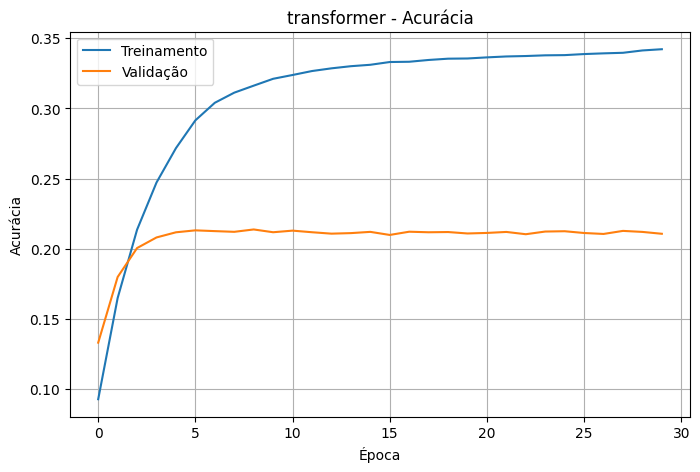

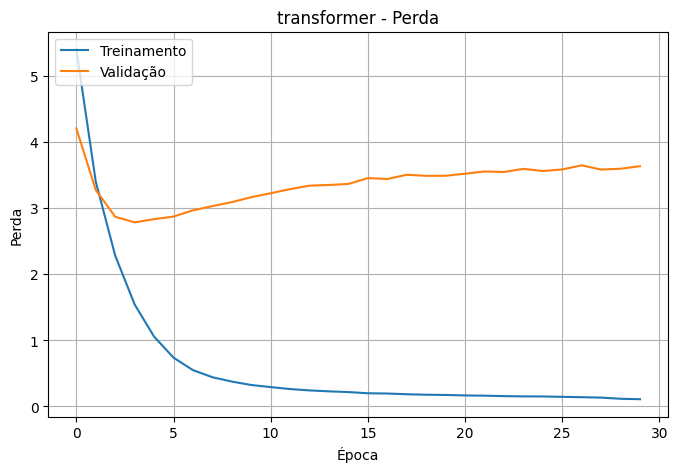

In [35]:
# =============================================================================
# Visualização do Histórico de Treinamento: Acurácia e Perda
# =============================================================================

# --- Resumo do histórico de acurácia ---
plt.figure(figsize=(8, 5))  # Define o tamanho da figura
plt.plot(history.history['accuracy'], label='Treinamento')         # Acurácia no treinamento
plt.plot(history.history['val_accuracy'], label='Validação')       # Acurácia na validação
plt.title(f'{transformer.name} - Acurácia')                              # Título do gráfico com o nome do modelo
plt.ylabel('Acurácia')                                            # Rótulo do eixo Y
plt.xlabel('Época')                                               # Rótulo do eixo X
plt.legend(loc='upper left')                                      # Legenda posicionada no canto superior esquerdo
plt.grid(True)                                                    # Adiciona uma grade ao gráfico
plt.show()                                                        # Exibe o gráfico

# --- Resumo do histórico de perda ---
plt.figure(figsize=(8, 5))  # Define o tamanho da figura
plt.plot(history.history['loss'], label='Treinamento')            # Perda no treinamento
plt.plot(history.history['val_loss'], label='Validação')          # Perda na validação
plt.title(f'{transformer.name} - Perda')                                # Título do gráfico com o nome do modelo
plt.ylabel('Perda')                                              # Rótulo do eixo Y
plt.xlabel('Época')                                              # Rótulo do eixo X
plt.legend(loc='upper left')                                     # Legenda posicionada no canto superior esquerdo
plt.grid(True)                                                   # Adiciona uma grade ao gráfico
plt.show()                                                       # Exibe o gráfico
